In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


df = pd.read_csv("../data/processed/BTC_finaldb_fct.csv")
del df['Open']
del df['High']
del df['Low']

df = df.iloc[:, 3:]

df['return'] = (df.Close - df.Close.shift(1))/df.Close.shift(1)

df['date'] = pd.to_datetime(df['date'])

df.head()

,Close,Volume,CloseTime,QuoteAssetVolume,NumberofTrade,TakerbuybaseV,TakerbuyquoteV,date,tweet_count,daily_sent,...,MA_7,MA_30,MA_100,ADX_2_4,RSI_14,MACD_3_14,MACDsign_3_14,MACDdiff_3_14,Mass Index,return
0,4285.08,795.150377,1503014399999,3.454770e+06,3427,616.248541,2.678216e+06,2017-08-17,5.0,0.095820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4108.37,1199.888264,1503100799999,5.086958e+06,5233,972.868710,4.129123e+06,2017-08-18,3.0,0.324533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.041238
2,4139.98,381.309763,1503187199999,1.549484e+06,2153,274.336042,1.118002e+06,2017-08-19,5.0,0.153140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007694
3,4086.29,467.083022,1503273599999,1.930364e+06,2321,376.795947,1.557401e+06,2017-08-20,1.0,0.540000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.012969
4,4016.00,691.743060,1503359999999,2.797232e+06,3972,557.356107,2.255663e+06,2017-08-21,3.0,0.000000,...,NaN,NaN,NaN,0.860061,NaN,NaN,NaN,NaN,NaN,-0.017201


In [2]:
!pip install tensorflow
!pip install gpflow

In [3]:
#inspect the data
df = df.dropna()
dff = df.drop(['date'], 1)

plt.figure(figsize = (20,8))
sns.heatmap(dff.corr(), annot=True)
plt.clf()

print("DF length ", len(df))

plt.figure()

DF length  1231


<Figure size 432x288 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## PCA analysis

Text(0, 0.5, 'cumulative explained variance')

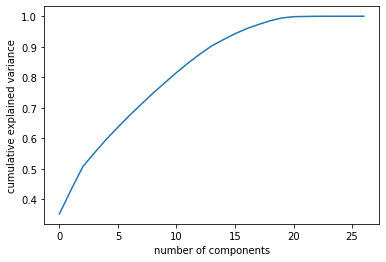

In [4]:
#PCA Analysis + Data scaling

from sklearn.decomposition import PCA # for PCA calculation
from sklearn.preprocessing import StandardScaler


dff = df.drop(['date', 'return', 'Close'], 1)

X = dff
sc = StandardScaler() # creating a StandardScaler object
X_std = sc.fit_transform(X) # standardizing the data

pca = PCA()
X_pca = pca.fit(X_std)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [5]:
pca = PCA(n_components = 19)
X_pca = pca.fit_transform(X_std)

X = X_pca
y = df['return']
print(X.shape)
print(y.shape)

l = int(0.9*len(X))
X_train = X[:l]
Y_train = y[:l]

X_test = X[l:]
Y_test = y[l:]

df_train_date = df['date'].iloc[:l]
df_test_date = df['date'].iloc[l:]

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(1231, 19)
(1231,)
(1107, 19)
(1107,)
(124, 19)
(124,)


## GPFlow

In [6]:
import tensorflow as tf
import gpflow as gp
gp.config.set_default_summary_fmt("notebook")
import numpy as np


approx = gp.models.GPR(data=(X_train, Y_train), kernel=gp.kernels.SquaredExponential(lengthscales= np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])), mean_function=None)
gp.utilities.print_summary(approx)
# optimize hp
optimizer = gp.optimizers.Scipy()
optimizer.minimize(approx.training_loss, approx.trainable_variables, options=dict(maxiter=100))
gp.utilities.print_summary(approx)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(19,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0017518883080867961
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(19,)",float64,"[670231.55505787, 739794.93572181, 841607.36910454..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


(124, 19)


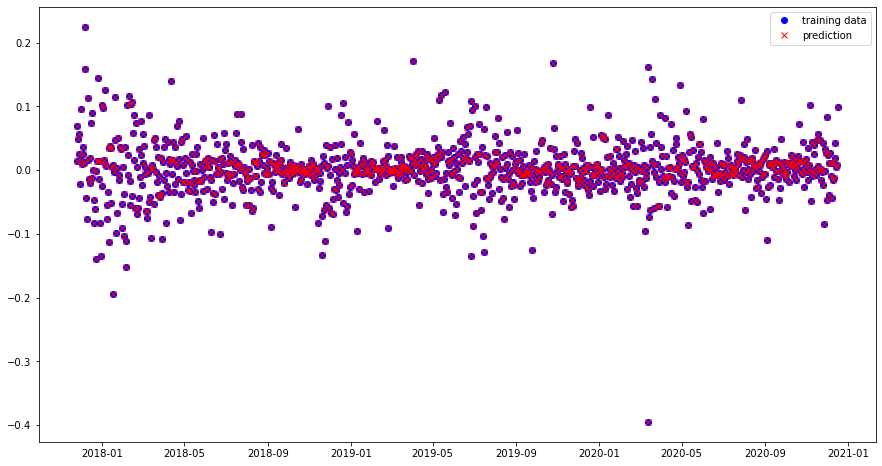

In [7]:
# make predictions
Y_train_approx, var_train_approx = approx.predict_f(X_train)
print(X_test.shape)
Y_test_approx, var_test_approx = approx.predict_y(X_test)


Y_train_approx = Y_train_approx[0]
Y_test_approx = Y_test_approx[0]



plt.figure(figsize=(15,8))
plt.plot(df_train_date, Y_train, 'bo', label = 'training data')
plt.plot(df_train_date, Y_test_approx, 'rx', label = 'prediction')
plt.legend()
plt.show()

## SKLEARN

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel  as C, ExpSineSquared
from sklearn.gaussian_process.kernels import Matern

kernel = Matern(length_scale=0.1, length_scale_bounds=(1e-05,1000000.0))
kernel =  C() * Matern() 

dy = 1e-5
gp = GaussianProcessRegressor(kernel=kernel, alpha = dy,  n_restarts_optimizer=9) 

gp.fit(X_train, Y_train)
Y_pred, sigma = gp.predict(X_test, return_std=True)

print(Y_pred.shape)

(124,)


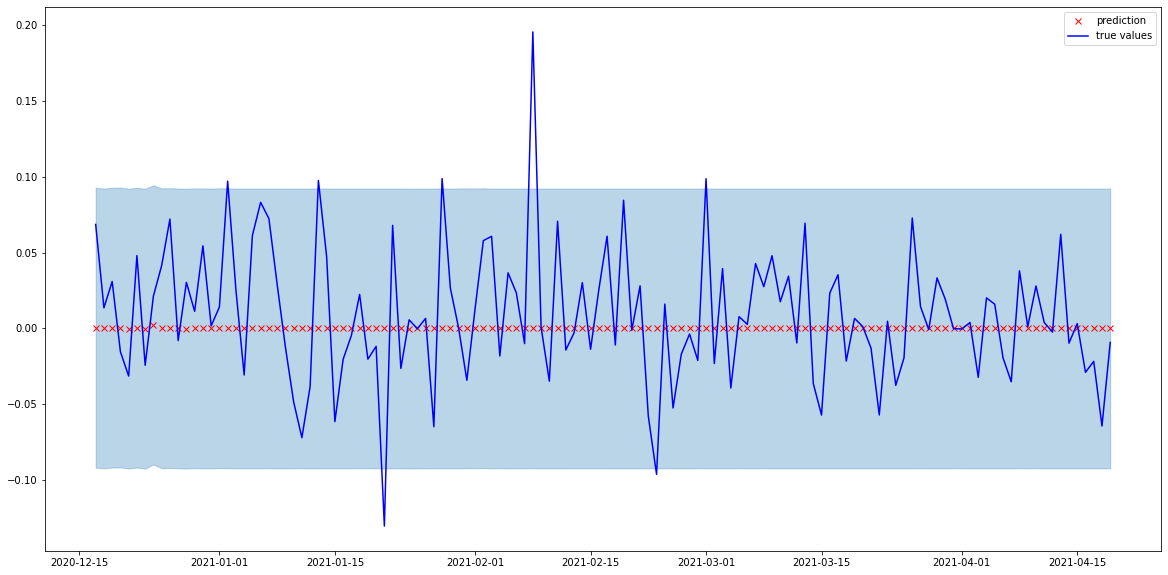

In [9]:
plt.figure(figsize=(20,10))
#plt.plot(df_train_date, Y_train, 'bo', label = 'training data')
plt.plot(df_test_date, Y_pred, 'rx', label = 'prediction')
plt.plot(df_test_date, Y_test, 'b-', label = 'true values')
plt.fill_between(df_test_date, Y_pred + 1.96 * sigma, Y_pred - 1.96 * sigma, alpha = 0.3, color ='C0')
plt.legend()
plt.show()

## Price prediction

In [10]:
#Predict prices

print(df.columns)
df = df.dropna()

Y = df['Close']

X = X_pca


l = int(0.9*len(X))
X_train = X[:l]
Y_train = Y[:l]

X_test = X[l:]
Y_test = Y[l:]

df_train_date = df['date'].iloc[:l]
df_test_date = df['date'].iloc[l:]

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)


Index(['Close', 'Volume', 'CloseTime', 'QuoteAssetVolume', 'NumberofTrade',
       'TakerbuybaseV', 'TakerbuyquoteV', 'date', 'tweet_count', 'daily_sent',
       'elonmusk', 'michael_saylor', 'binance', 'peterlbrandt', 'apompliano',
       'cashapp', 'investingcom', 'coinmarketcap', 'raoulgmi',
       'charliebilello', 'MA_7', 'MA_30', 'MA_100', 'ADX_2_4', 'RSI_14',
       'MACD_3_14', 'MACDsign_3_14', 'MACDdiff_3_14', 'Mass Index', 'return'],
      dtype='object')
(1107, 19)
(1107,)
(124, 19)
(124,)


## SKLEARN PRICE

In [15]:
print("here")
kernel = ExpSineSquared()

dy = 1e-3
gp = GaussianProcessRegressor(kernel=kernel, alpha = dy,  n_restarts_optimizer=9) 

print(Y_train.shape)
print(X_train.shape)
print("Fitting...")
gp.fit(X_train, Y_train)
print("Finished fitting!")
Y_pred, sigma = gp.predict(X_test, return_std=True)



print(Y_pred)

here
(1107,)
(1107, 19)
Fitting...
Finished fitting!
[0.00000000e+000 0.00000000e+000 2.29674637e-053 2.56800869e+001
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 3.42083571e-068
 9.56749113e-040 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 7.97086422e+002 2.19269274e-060 2.07385493e-249
 0.00000000e+000 2.41709619e+000 0.00000000e+000 2.57818215e-069
 9.53430205e-039 0.00000000e+000 6.88828332e-083 0.00000000e+000
 3.31787385e-001 0.00000000e+000 0.00000000e+000 9.40917412e-009
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 2.38802592e-007 0.00000000e+000 5.14026260e-033 0.00000000e+000
 0.00000000e+000 0.00000000e+000 2.13162305e+001 0.00000000e+000
 0.00000000e+000 0.00000000e+000 2.09803902e-235 3.76322187e-044
 1.09416792e+000 0.00000000e+000 1.45009035e+002 2.21042317e-207
 5.57653385e-037 0.00000000e+000 8.84002391e-222 0.00000000e+000
 5.76908554e-279 6.41575256e+003 0.00

<Figure size 432x288 with 0 Axes>

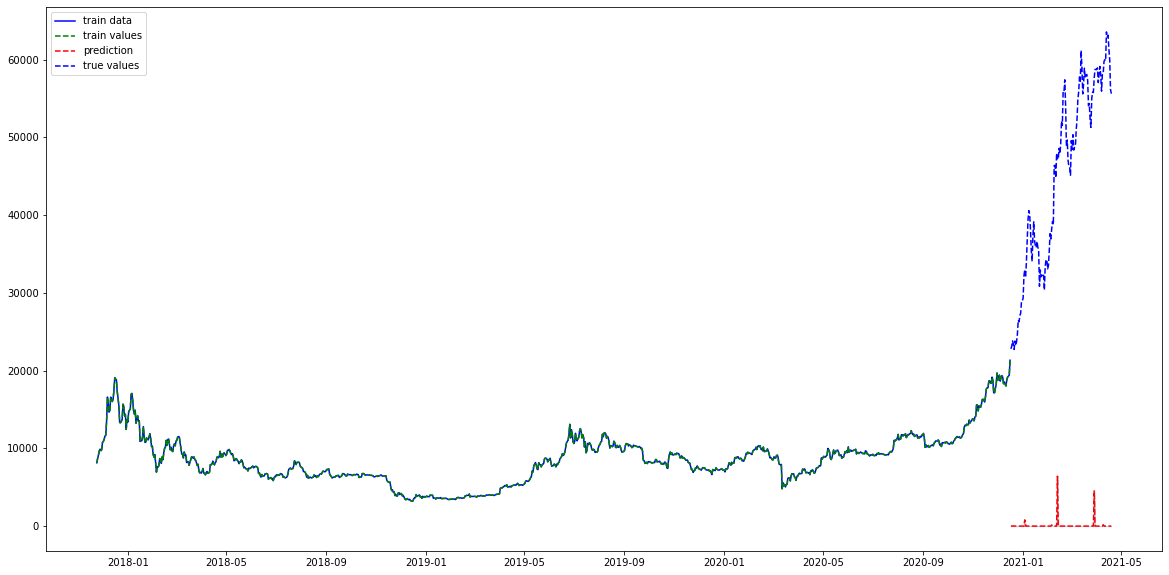

In [20]:
plt.clf()

Y_pred_train, sigma2 = gp.predict(X_train, return_std=True)
plt.figure(figsize=(20,10))
#plt.plot(df_train_date, Y_train, 'bo', label = 'training data')
plt.plot(df_train_date, Y_train, 'b-', label = 'train data')
plt.plot(df_train_date, Y_pred_train, 'g--', label='train values')
plt.plot(df_test_date, Y_pred, 'r--', label = 'prediction')
plt.plot(df_test_date, Y_test, 'b--', label = 'true values')

plt.fill_between(df_test_date, Y_pred + 1.96 * sigma, Y_pred - 1.96 * sigma, alpha = 0.3, color ='C0')
plt.legend()
plt.show()